===== 情绪指数滞后相关性分析结果 =====
   滞后天数  情绪值_涨跌幅相关系数        P值 是否显著
0     1       0.0356  0.056189    否
1     3       0.0269  0.149427    否
2     5       0.0228  0.220792    否


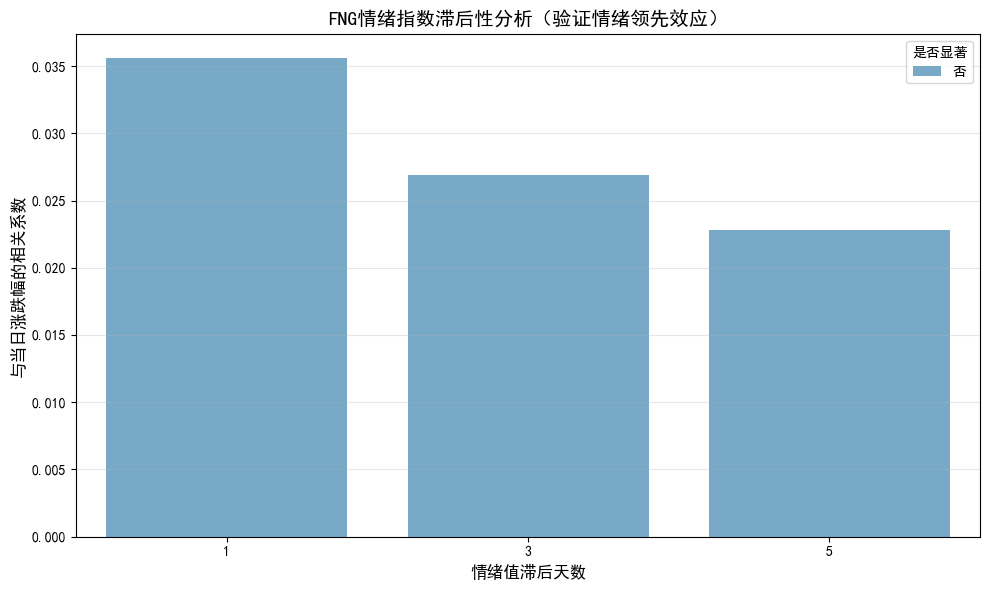

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

# ========== 1. 数据准备 ==========
result_dir = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\结果数据"
data_path = r"C:\Users\33759\Desktop\自选动作 陈正扬 2326010229\修改后数据\BTC_FNG_清洗后数据.xlsx"
df = pd.read_excel(data_path)
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values('日期').reset_index(drop=True)

# ========== 2. 构建滞后变量（情绪值滞后1/3/5天） ==========
lags = [1, 3, 5]  # 滞后1/3/5天
for lag in lags:
    df[f'情绪值_滞后{lag}天'] = df['情绪值'].shift(lag)  # 情绪值滞后N天
    df[f'涨跌幅_滞后{lag}天'] = df['涨跌幅（百分比）'].shift(lag)  # 涨跌幅滞后N天

# 删除滞后产生的缺失值
df_lag = df.dropna(subset=[f'情绪值_滞后{lag}天' for lag in lags])

# ========== 3. 计算滞后相关性（核心：情绪→未来涨跌幅） ==========
lag_corr_results = []
for lag in lags:
    # 滞后N天情绪值 vs 当日涨跌幅（验证情绪领先性）
    corr_coef, p_value = pearsonr(df_lag[f'情绪值_滞后{lag}天'], df_lag['涨跌幅（百分比）'])
    # 列名替换为下划线（避免特殊符号）
    lag_corr_results.append({
        '滞后天数': lag,
        '情绪值_涨跌幅相关系数': round(corr_coef, 4),
        'P值': round(p_value, 6),
        '是否显著': '是' if p_value < 0.05 else '否'
    })

# 格式化输出结果
lag_corr_df = pd.DataFrame(lag_corr_results)
print("===== 情绪指数滞后相关性分析结果 =====")
print(lag_corr_df)

# 保存结果
lag_corr_df.to_excel(
    os.path.join(result_dir, "深度分析1_情绪滞后相关性.xlsx"),
    index=False,
    engine='openpyxl'
)

# ========== 4. 可视化：不同滞后天数的相关性对比 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x='滞后天数',
    y='情绪值_涨跌幅相关系数',  # 使用替换后的列名
    data=lag_corr_df,
    palette='Blues',
    hue='是否显著',
    dodge=False
)

# 添加显著性标记（使用替换后的列名）
for i, row in enumerate(lag_corr_df.itertuples()):
    if row.是否显著 == '是':
        ax.text(i, row.情绪值_涨跌幅相关系数 + 0.01, '*', fontsize=16, ha='center')

ax.set_xlabel('情绪值滞后天数', fontsize=12)
ax.set_ylabel('与当日涨跌幅的相关系数', fontsize=12)
ax.set_title('FNG情绪指数滞后性分析（验证情绪领先效应）', fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(result_dir, "深度分析1_情绪滞后相关性图.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()